In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm

# Data Loading and Preprocessing
def load_all_folds(base_path):
    folds = ["Fold 1", "Fold 2", "Fold 3"]
    all_images, all_masks, all_types = [], [], []
    
    for fold in folds:
        fold_path = os.path.join(base_path, fold)
        images = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "images.npy"))
        masks = np.load(os.path.join(fold_path, "masks", f"fold{fold[-1]}", "masks.npy"))
        types = np.load(os.path.join(fold_path, "images", f"fold{fold[-1]}", "types.npy"))
        
        all_images.append(images)
        all_masks.append(masks)
        all_types.append(types)
    
    return all_images, all_masks, all_types

base_path = "/rsrch5/home/plm/yshokrollahi/vitamin-p/vitamin-p/data/raw/H&E"
all_images, all_masks, all_types = load_all_folds(base_path)

def create_train_val_test_split(all_images, all_masks, all_types):
    splits = []
    
    for test_fold in range(3):
        train_val_folds = [i for i in range(3) if i != test_fold]
        
        train_val_images = np.concatenate([all_images[i] for i in train_val_folds])
        train_val_masks = np.concatenate([all_masks[i] for i in train_val_folds])
        train_val_types = np.concatenate([all_types[i] for i in train_val_folds])
        
        num_samples = len(train_val_images)
        num_val = num_samples // 10
        
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        
        val_indices = indices[:num_val]
        train_indices = indices[num_val:]
        
        split = {
            'train': {
                'images': train_val_images[train_indices],
                'masks': train_val_masks[train_indices],
                'types': train_val_types[train_indices]
            },
            'val': {
                'images': train_val_images[val_indices],
                'masks': train_val_masks[val_indices],
                'types': train_val_types[val_indices]
            },
            'test': {
                'images': all_images[test_fold],
                'masks': all_masks[test_fold],
                'types': all_types[test_fold]
            }
        }
        
        splits.append(split)
    
    return splits

data_splits = create_train_val_test_split(all_images, all_masks, all_types)


/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CellSegmentationDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]


        # Normalize image to 0-1 range
        image = (image - image.min()) / (image.max() - image.min())
        
        # Create binary mask from the last channel
        binary_mask = (mask[..., 5] > 0).astype(np.float32)


        if self.image_transform:
            image = self.image_transform(image)


        if self.mask_transform:
            binary_mask = self.mask_transform(binary_mask)

        return image, binary_mask


# Choose a split (0, 1, or 2)
chosen_split = 0

# Define transforms
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float())
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float())
])

# Create datasets
train_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['train']['images'],
    data_splits[chosen_split]['train']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)

val_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['val']['images'],
    data_splits[chosen_split]['val']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# After creating the datasets, add these lines:
print("\nChecking first item in train_dataset:")
image, mask = train_dataset[0]
print(f"Final image shape: {image.shape}, dtype: {image.dtype}")
print(f"Final mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Final image min: {image.min().item():.4f}, max: {image.max().item():.4f}")
print(f"Final mask min: {mask.min().item():.4f}, max: {mask.max().item():.4f}")


print('done')
print('done')


Checking first item in train_dataset:
Final image shape: torch.Size([3, 256, 256]), dtype: torch.float32
Final mask shape: torch.Size([1, 256, 256]), dtype: torch.float32
Final image min: 0.0000, max: 1.0000
Final mask min: 0.0000, max: 1.0000
done
done


## Data visualization

Visualizing first sample from training dataset:
Original image - min: 2.0, max: 255.0, mean: 159.26974487304688
Normalized image - min: 0.0, max: 1.0, mean: 0.6216195449527545


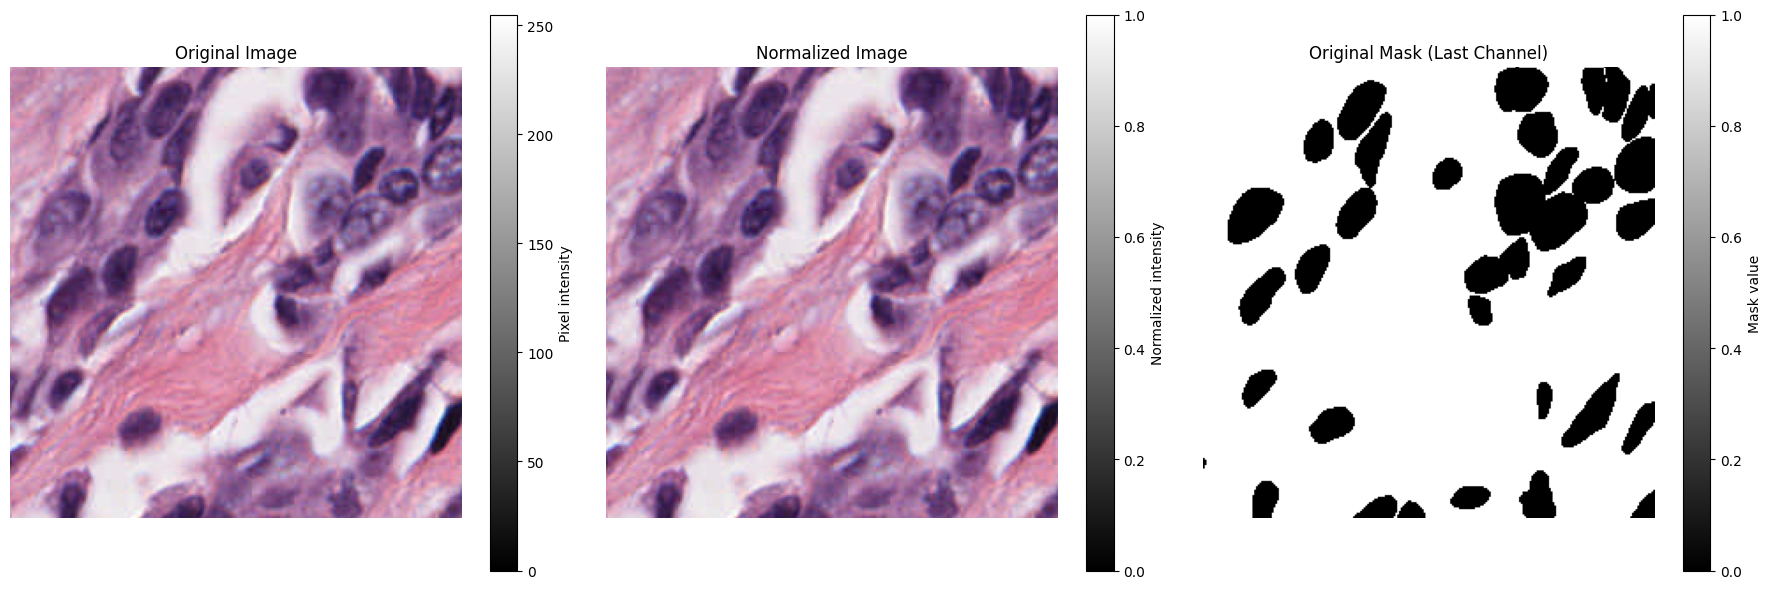

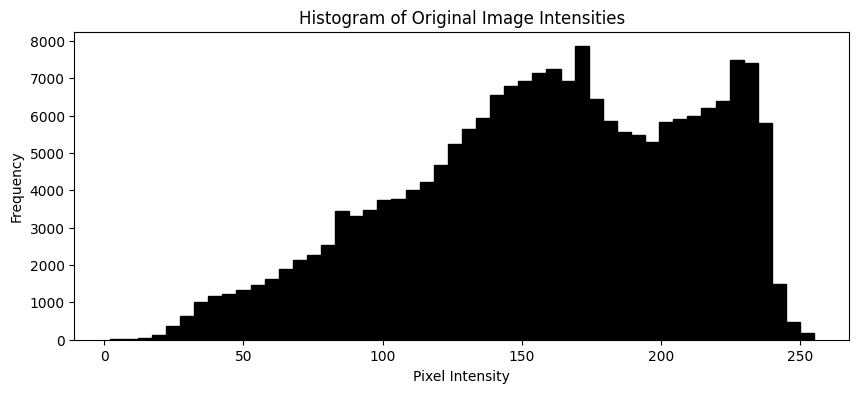

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_single_sample(dataset, index=0):
    # Get the original image and mask
    original_image = dataset.images[index]
    original_mask = dataset.masks[index]

    # Normalize image as done in the dataset class
    normalized_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

    print(f"Original image - min: {original_image.min()}, max: {original_image.max()}, mean: {original_image.mean()}")
    print(f"Normalized image - min: {normalized_image.min()}, max: {normalized_image.max()}, mean: {normalized_image.mean()}")

    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the original image
    # Plot the original image with adjusted vmin and vmax
    im1 = ax1.imshow(original_image.astype(np.uint8), cmap='gray', vmin=0, vmax=255)
    ax1.set_title("Original Image")
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, label='Pixel intensity')

    # Plot the normalized image
    im2 = ax2.imshow(normalized_image, cmap='gray')
    ax2.set_title("Normalized Image")
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, label='Normalized intensity')

    # Plot the original mask (last channel)
    im3 = ax3.imshow(original_mask[..., -1], cmap='gray')
    ax3.set_title("Original Mask (Last Channel)")
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, label='Mask value')

    plt.tight_layout()
    plt.show()

    # Display histogram of original image intensities
    plt.figure(figsize=(10, 4))
    plt.hist(original_image.ravel(), bins=50, range=(original_image.min(), original_image.max()), fc='k', ec='k')
    plt.title("Histogram of Original Image Intensities")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Visualize the first sample from the training dataset
print("Visualizing first sample from training dataset:")
visualize_single_sample(train_dataset)

## model training 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

class ViTEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        if pretrained:
            weights = ViT_B_16_Weights.IMAGENET1K_V1
        else:
            weights = None
        self.vit = vit_b_16(weights=weights)
        self.vit.heads = nn.Identity()  # Remove classification head

    def forward(self, x):
        if x.shape[-2:] != (224, 224):
            x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        
        x = self.vit.conv_proj(x)
        x = x.flatten(2).transpose(1, 2)
        
        cls_token = self.vit.class_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.vit.encoder.pos_embedding
        
        features = []
        for i, block in enumerate(self.vit.encoder.layers):
            x = block(x)
            if i in [3, 7, 11]:
                feature = x[:, 1:, :]
                h = w = int((feature.shape[1]) ** 0.5)
                features.append(feature.transpose(1, 2).view(feature.shape[0], feature.shape[2], h, w))
        
        return features

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        return x

class UNetDecoder(nn.Module):
    def __init__(self, encoder_dim=768):
        super().__init__()
        self.decoder1 = DecoderBlock(encoder_dim, 256)
        self.decoder2 = DecoderBlock(256 + encoder_dim, 128)
        self.decoder3 = DecoderBlock(128 + encoder_dim, 64)
        self.decoder4 = DecoderBlock(64, 32)
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        x = features[-1]
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.decoder1(x)
        
        x = torch.cat([x, F.interpolate(features[-2], size=x.shape[-2:], mode='bilinear', align_corners=False)], dim=1)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.decoder2(x)
        
        x = torch.cat([x, F.interpolate(features[-3], size=x.shape[-2:], mode='bilinear', align_corners=False)], dim=1)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.decoder3(x)
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.decoder4(x)
        
        x = self.final_conv(x)
        return self.sigmoid(x)

class CellViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ViTEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        original_size = x.shape[-2:]
        features = self.encoder(x)
        output = self.decoder(features)
        if output.shape[-2:] != original_size:
            output = F.interpolate(output, size=original_size, mode='bilinear', align_corners=False)
        return output

print("Model classes defined.")

Model classes defined.


In [5]:
class BinaryCrossEntropyDiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(BinaryCrossEntropyDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        bce = F.binary_cross_entropy(pred, target, reduction='mean')
        
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = 1 - (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return bce + dice

def iou_score(pred, target, smooth=1e-5):
    pred = (pred > 0.5).float()
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

print("Loss function and metrics defined.")

Loss function and metrics defined.


In [6]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = BinaryCrossEntropyDiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
        for images, masks in train_bar:
            images = images.float().to(device)
            masks = masks.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_iou += iou_score(outputs, masks).item()
            train_bar.set_postfix({'loss': f"{loss.item():.4f}", 'iou': f"{iou_score(outputs, masks).item():.4f}"})
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        val_iou = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")
        with torch.no_grad():
            for images, masks in val_bar:
                images = images.float().to(device)
                masks = masks.float().to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_iou += iou_score(outputs, masks).item()
                val_bar.set_postfix({'loss': f"{loss.item():.4f}", 'iou': f"{iou_score(outputs, masks).item():.4f}"})
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}')
        
        scheduler.step(avg_val_loss)
    
    return model

print("Training function defined.")

Training function defined.


In [14]:
# Initialize the model
model = CellViT().float()

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=5)



Epoch 1/5 - Validation: 100%|██████████| 33/33 [00:01<00:00, 25.49it/s, loss=0.6378, iou=0.8315]


Epoch 1/5:
Train Loss: 0.6628, Train IoU: 0.8589
Val Loss: 0.5956, Val IoU: 0.8364


Epoch 2/5 - Validation: 100%|██████████| 33/33 [00:01<00:00, 23.44it/s, loss=0.5045, iou=0.8994]


Epoch 2/5:
Train Loss: 0.5207, Train IoU: 0.8963
Val Loss: 0.5104, Val IoU: 0.8928


Epoch 3/5 - Validation: 100%|██████████| 33/33 [00:01<00:00, 22.84it/s, loss=0.4064, iou=0.9040]


Epoch 3/5:
Train Loss: 0.4369, Train IoU: 0.9033
Val Loss: 0.4173, Val IoU: 0.8980


Epoch 4/5 - Validation: 100%|██████████| 33/33 [00:01<00:00, 24.83it/s, loss=0.4002, iou=0.8952]


Epoch 4/5:
Train Loss: 0.3809, Train IoU: 0.9058
Val Loss: 0.4230, Val IoU: 0.8746


Epoch 5/5 - Validation: 100%|██████████| 33/33 [00:01<00:00, 25.04it/s, loss=0.3056, iou=0.9161]


Epoch 5/5:
Train Loss: 0.3356, Train IoU: 0.9101
Val Loss: 0.3293, Val IoU: 0.9037


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import random

def visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3):
    model.eval()
    
    # Randomly select indices
    indices = random.sample(range(len(test_dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    overall_f1 = 0
    overall_precision = 0
    overall_recall = 0
    
    for i, idx in enumerate(indices):
        image, mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            output = model(image)
        
        image = image.cpu().numpy().transpose(0, 2, 3, 1).squeeze()
        mask = mask.cpu().numpy().squeeze()
        output = output.cpu().numpy().squeeze()
        
        # Calculate metrics
        pred_mask = (output > 0.5).astype(np.uint8)
        f1 = f1_score(mask.flatten(), pred_mask.flatten(), average='binary')
        precision = precision_score(mask.flatten(), pred_mask.flatten(), average='binary')
        recall = recall_score(mask.flatten(), pred_mask.flatten(), average='binary')
        
        overall_f1 += f1
        overall_precision += precision
        overall_recall += recall
        
        # Plotting
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Input Image {idx}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"True Mask {idx}")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask {idx}\nF1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print overall metrics
    overall_f1 /= num_samples
    overall_precision /= num_samples
    overall_recall /= num_samples
    
    print(f"Overall Metrics (average of {num_samples} samples):")
    print(f"F1 Score: {overall_f1:.4f}")
    print(f"Precision: {overall_precision:.4f}")
    print(f"Recall: {overall_recall:.4f}")

print("Enhanced visualization function with metrics defined.")

# Usage example (you'll need to define these variables):
# model = your_trained_model
# test_dataset = your_test_dataset
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# visualize_prediction_with_metrics(model, test_dataset, device)

Enhanced visualization function with metrics defined.


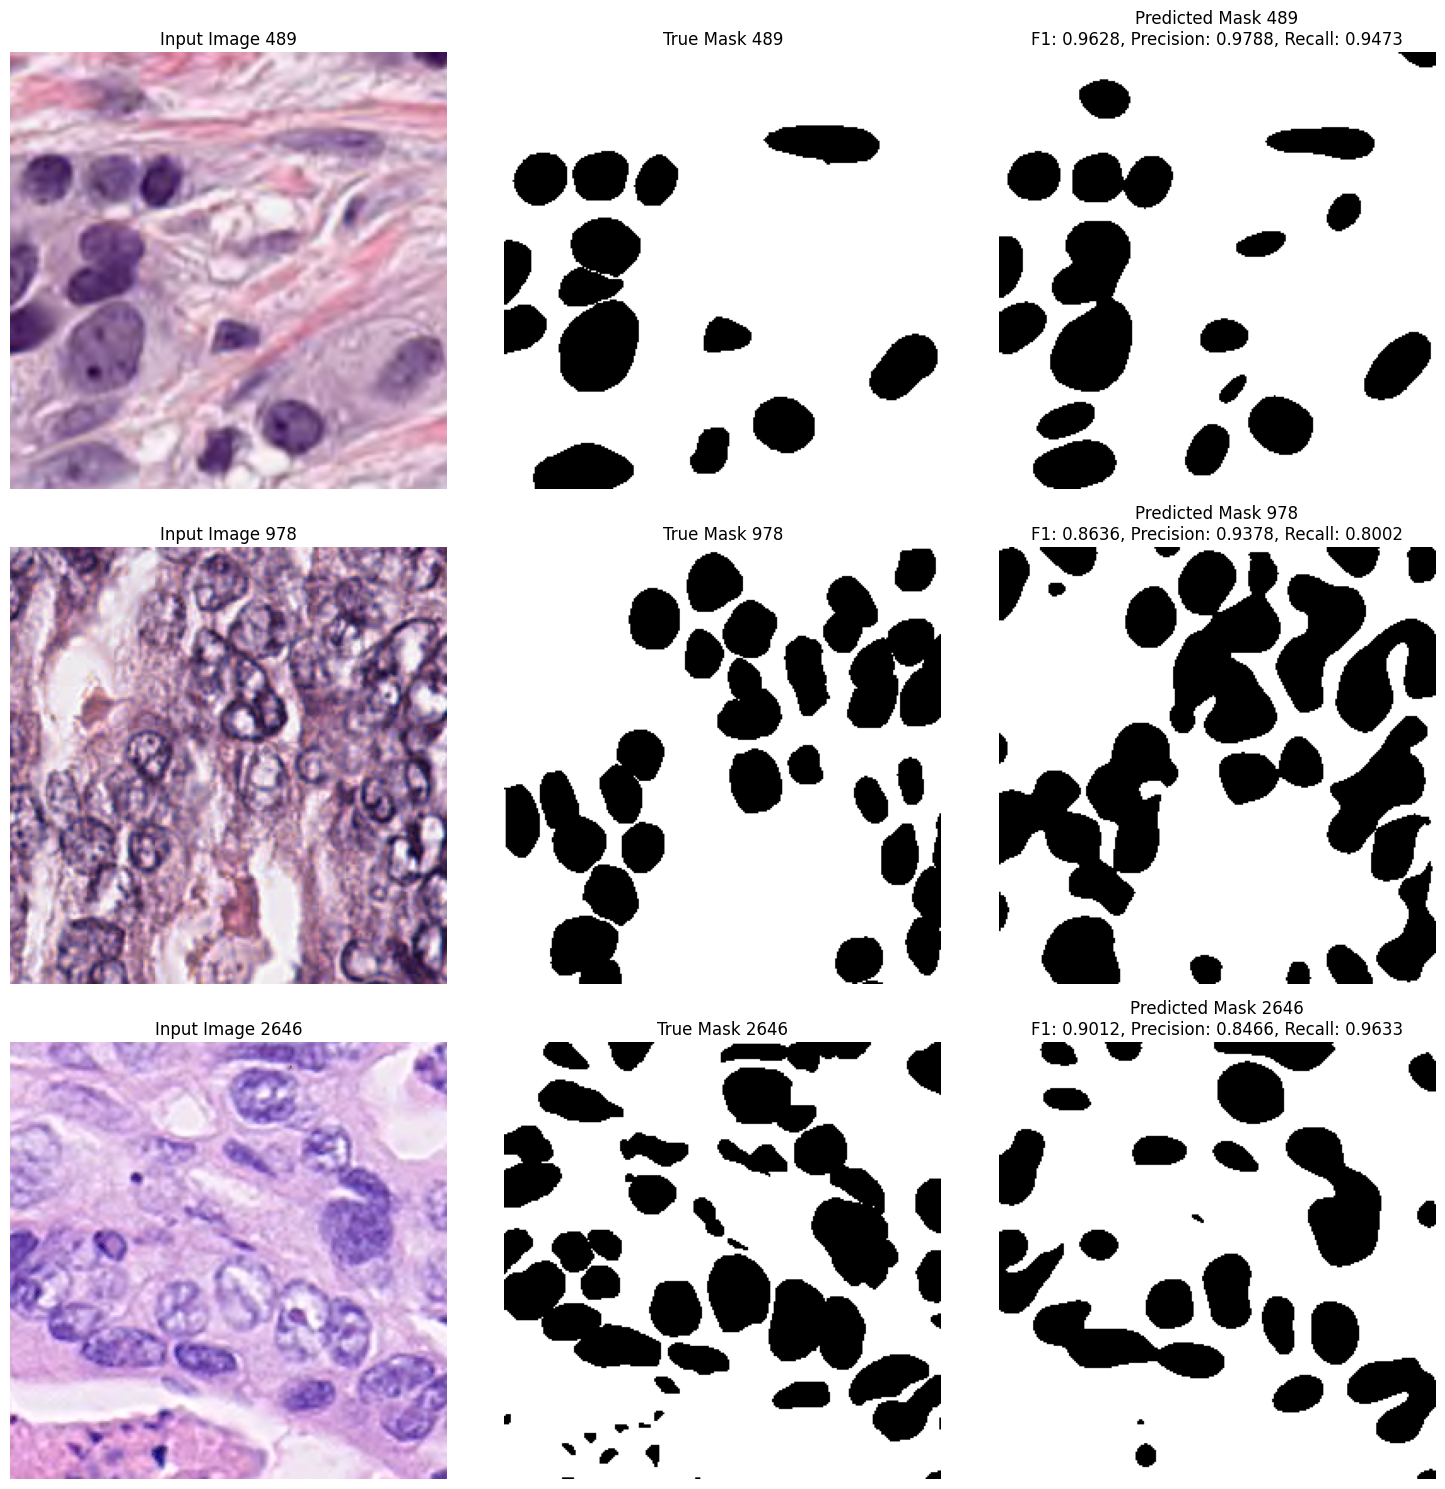

Overall Metrics (average of 3 samples):
F1 Score: 0.9092
Precision: 0.9211
Recall: 0.9036


In [30]:
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize and calculate metrics
visualize_prediction_with_metrics(model, test_dataset, device, num_samples=3)

In [22]:
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
from torch.utils.data import DataLoader

def calculate_metrics_across_all_test_sets(model, test_dataset, device, batch_size=32):
    model.eval()
    
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_true_masks = []
    all_pred_masks = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Ensure images are in the correct shape (B, C, H, W)
            if images.dim() == 3:
                images = images.unsqueeze(1)  # Add channel dimension if missing
            
            if images.shape[-2:] != (224, 224):
                images = torch.nn.functional.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            
            outputs = model(images)
            pred_masks = (outputs > 0.5).float()
            
            # Resize pred_masks back to original size if necessary
            if pred_masks.shape[-2:] != masks.shape[-2:]:
                pred_masks = torch.nn.functional.interpolate(pred_masks, size=masks.shape[-2:], mode='nearest')
            
            all_true_masks.extend(masks.cpu().numpy().flatten())
            all_pred_masks.extend(pred_masks.cpu().numpy().flatten())
    
    all_true_masks = np.array(all_true_masks)
    all_pred_masks = np.array(all_pred_masks)
    
    f1 = f1_score(all_true_masks, all_pred_masks, average='binary')
    precision = precision_score(all_true_masks, all_pred_masks, average='binary')
    recall = recall_score(all_true_masks, all_pred_masks, average='binary')
    
    print("Metrics across all test sets:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return f1, precision, recall

# Usage
model = trained_model  # Your trained CellViT model
test_dataset = CellSegmentationDataset(
    data_splits[chosen_split]['test']['images'],
    data_splits[chosen_split]['test']['masks'],
    image_transform=image_transform,
    mask_transform=mask_transform
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate metrics across all test sets
f1, precision, recall = calculate_metrics_across_all_test_sets(model, test_dataset, device)

Evaluating: 100%|██████████| 83/83 [00:17<00:00,  4.73it/s]


Metrics across all test sets:
F1 Score: 0.9534
Precision: 0.9570
Recall: 0.9499
